In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.model_selection import ParameterGrid

from recsys4daos.models import NLPSimilarity
from recsys4daos.utils import Timer
from recsys4daos.datasets import to_microsoft
from recsys4daos.evaluation import calculate_all_metrics
from recsys4daos.model_selection import cvtt_open, explore_hparams

import paths

import seaborn as sns
sns.set_theme()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/home/daviddavo/recsys4daos/.direnv/python-3.11/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Parameters

In [2]:
# Dataset config
ORG_NAME = 'Decentraland'

# Evaluation
K_RECOMMENDATIONS: list[int] = [1,3,5,10,15,100]
SPLITS_FREQ: str = 'W-THU' # split weekly
SPLITS_NORMALIZE = True # Wether or not to move everything to 00:00
LAST_FOLDS = 10 # Use just last 10 splits
LAST_FOLD_DATE_STR: str = None

# Search space config
WINDOW_SIZES = ['7d', '14d', '21d', '30d', '60d', '90d', '10YE']
PLN_MODEL_NAMES = [
    'all-mpnet-base-v2', # The one used in sbert's examples
    'all-distilroberta-v1',
    'all-MiniLM-L12-v2',
    'all-MiniLM-L6-v2',
]

OPTIM_METRIC = 'map@10'

In [3]:
# Parameters
EXECUTION_ID = "2024-09-04T10:00"
ORG_NAME = "Magic Square"
SPLITS_FREQ = "7d"
LAST_FOLDS = 10
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = "2023-07-17"


In [4]:
EMBEDDINGS_CACHE = Path(paths.DEFAULT_CACHE_PATH) / 'pln-embeddings'

# Load the dataset

In [5]:
dfp = paths.load_proposals(ORG_NAME, text=True)
dfv = paths.load_votes(ORG_NAME)

print(dfp.info())
print(dfv.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316 entries, 0 to 315
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 316 non-null    object        
 1   author             316 non-null    object        
 2   date               316 non-null    datetime64[us]
 3   start              316 non-null    datetime64[us]
 4   end                316 non-null    datetime64[us]
 5   platform_proposal  316 non-null    object        
 6   title              316 non-null    object        
 7   description        316 non-null    object        
dtypes: datetime64[us](3), object(5)
memory usage: 19.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899961 entries, 0 to 899960
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   id        899961 non-null  object        
 1   proposal  899961 non-null

In [6]:
df = to_microsoft(dfv)
df

,userID,itemID,timestamp,rating
0,0x2212d5f1e531d9786f12df2af0661cfd58cbae71,5611034c-c172-5e23-9c3b-1268fde09c85,2023-05-08 11:56:03,1
1,0x5f8ba595ede4554929a04a0ce9c0d7b31aa3661f,5611034c-c172-5e23-9c3b-1268fde09c85,2023-05-08 11:57:28,1
2,0xef6ad4fcaf7be57f244e617394b5968d3db9ffa0,5611034c-c172-5e23-9c3b-1268fde09c85,2023-05-08 11:57:48,1
3,0xa7db4f21096c45d9392affb9f9ed65110c2838d1,5611034c-c172-5e23-9c3b-1268fde09c85,2023-05-08 12:02:28,1
4,0xe39a6e7d1cfa126b2dcdba9bf8124ba403f37a68,5611034c-c172-5e23-9c3b-1268fde09c85,2023-05-08 12:02:33,1
...,...,...,...,...
899956,0xa607a4b265dd82fc99169faeb29470e2bf3566ce,cdcb5a6f-c0c6-5b1a-840b-85715450033b,2023-07-20 07:53:03,1
899957,0xa607a4b265dd82fc99169faeb29470e2bf3566ce,6b685db4-bf17-5c9a-9214-3ffa835699a3,2023-07-20 07:53:58,1
899958,0xa3d904e8cd2366d27724e0454cb5641cf1380be8,ceb1134c-c268-5d54-9ed6-4edbf129cd87,2023-07-20 08:15:16,1
899959,0xa3d904e8cd2366d27724e0454cb5641cf1380be8,6b685db4-bf17-5c9a-9214-3ffa835699a3,2023-07-20 08:15:59,1


## Split in folds

In [7]:
all_folds = { f.end:f for f in cvtt_open(
    df, SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', last_fold=LAST_FOLD_DATE_STR,
)}
last_folds_idx = list(all_folds.keys())[-LAST_FOLDS:]
last_folds_idx

[Timestamp('2023-05-15 00:00:00'),
 Timestamp('2023-05-22 00:00:00'),
 Timestamp('2023-05-29 00:00:00'),
 Timestamp('2023-06-05 00:00:00'),
 Timestamp('2023-06-12 00:00:00'),
 Timestamp('2023-06-19 00:00:00'),
 Timestamp('2023-06-26 00:00:00'),
 Timestamp('2023-07-03 00:00:00'),
 Timestamp('2023-07-10 00:00:00'),
 Timestamp('2023-07-17 00:00:00')]

# Similarity PLN

In [8]:
def testHParamsPLNSimilarity(fold, window_size, model_name):
    f = all_folds[fold]
    
    model = NLPSimilarity(dfp, EMBEDDINGS_CACHE, model_name=model_name)

    offset = pd.tseries.frequencies.to_offset(window_size)
    train = f.train[f.train['timestamp'] > (f.end - offset)]

    with Timer() as t_fit:
        model.fit(train)

    with Timer() as t_rec:
        # Truncate the top_k
        top_k = max(K_RECOMMENDATIONS)
        users = np.intersect1d(f.test['userID'].unique(), train['userID'].unique())
        recs = model.recommend_k_items(users, top_k=min(len(f.open_proposals), top_k), recommend_from=f.open_proposals)
    
    return {
        'time_train': t_fit.time,
        'time_rec': t_rec.time,
        'rec_users': len(users),
        **calculate_all_metrics(f.test, recs, K_RECOMMENDATIONS),
    }

# testHParamsPLNSimilarity(last_folds_idx[0], '14D', PLN_MODEL_NAMES[0])

In [9]:
# Populate the cache of embeddings for each model
from recsys4daos.models.nlp import NLPModel

for m in PLN_MODEL_NAMES:
    NLPModel(dfp, EMBEDDINGS_CACHE, model_name=m).fit()

In [10]:
results = explore_hparams(
    testHParamsPLNSimilarity,
    ParameterGrid({
        'fold': last_folds_idx,
        'model_name': PLN_MODEL_NAMES,
        'window_size': WINDOW_SIZES,
    }),
    paths.hparams_progress('pln-similarity', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE),
)
mdf = pd.DataFrame(results)
mdf

Restored checkpoint from ../.cache/Magic Square/hparams-pln-similarity_7d_normalize.pkl with 280 results


  0%|          | 0/280 [00:00<?, ?it/s]

,fold,model_name,window_size,time_train,time_rec,rec_users,precision@1,precision@3,precision@5,precision@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
0,2023-05-15,all-mpnet-base-v2,7d,2.967894,0.004320,259,0.787645,0.682111,0.551351,0.364865,...,0.980039,1.000000,1.0,0.404074,0.710748,0.820124,0.898606,0.907226,0.907226,0.210004
1,2023-05-15,all-mpnet-base-v2,14d,2.960884,0.004233,259,0.787645,0.682111,0.551351,0.364865,...,0.980039,1.000000,1.0,0.404074,0.710748,0.820124,0.898606,0.907226,0.907226,0.207220
2,2023-05-15,all-mpnet-base-v2,21d,2.789536,0.004152,259,0.787645,0.682111,0.551351,0.364865,...,0.980039,1.000000,1.0,0.404074,0.710748,0.820124,0.898606,0.907226,0.907226,0.207586
3,2023-05-15,all-mpnet-base-v2,30d,2.956083,0.004141,259,0.787645,0.682111,0.551351,0.364865,...,0.980039,1.000000,1.0,0.404074,0.710748,0.820124,0.898606,0.907226,0.907226,0.207599
4,2023-05-15,all-mpnet-base-v2,60d,2.777296,0.004164,259,0.787645,0.682111,0.551351,0.364865,...,0.980039,1.000000,1.0,0.404074,0.710748,0.820124,0.898606,0.907226,0.907226,0.208069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,2023-07-17,all-MiniLM-L6-v2,21d,2563.904513,0.080199,1270,0.729134,0.452756,0.333701,0.230551,...,0.965732,0.993570,1.0,0.833314,0.820321,0.841064,0.877896,0.889048,0.890453,0.393157
276,2023-07-17,all-MiniLM-L6-v2,30d,2968.540948,0.092326,1345,0.698141,0.438662,0.326394,0.233978,...,0.947963,0.978463,1.0,0.822730,0.810882,0.834507,0.873305,0.886878,0.888778,0.411787
277,2023-07-17,all-MiniLM-L6-v2,60d,3924.932705,0.130858,1439,0.667130,0.414640,0.319666,0.244058,...,0.929786,0.965935,1.0,0.806180,0.781085,0.803973,0.848083,0.866051,0.868746,0.433179
278,2023-07-17,all-MiniLM-L6-v2,90d,3953.993235,0.134541,1463,0.658920,0.415129,0.319891,0.247915,...,0.924201,0.964452,1.0,0.803094,0.770357,0.792971,0.839171,0.857795,0.860638,0.437290


<Axes: xlabel='window_size', ylabel='map@10'>

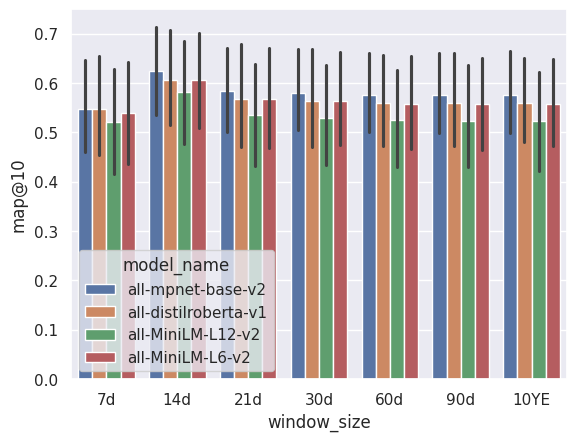

In [11]:
sns.barplot(mdf, x='window_size', y=OPTIM_METRIC, hue='model_name')

## Best overall hparams

In [12]:
display_columns = ['time_train'] + [ c for c in mdf.columns if c.endswith('@5') or c.endswith('@10') or c.endswith('@100') ]
hparam_cols = ['window_size', 'model_name']
overall_hparams = mdf[mdf['fold'] > last_folds_idx[0]].groupby(hparam_cols).mean().sort_values(OPTIM_METRIC, ascending=False)
overall_hparams[display_columns]

time_train  precision@5  precision@10  \
window_size model_name                                                     
14d         all-mpnet-base-v2      630.075884     0.496158      0.419307   
            all-distilroberta-v1   632.987998     0.467373      0.402290   
            all-MiniLM-L6-v2       548.135156     0.466095      0.409990   
21d         all-mpnet-base-v2      994.735737     0.473815      0.413625   
14d         all-MiniLM-L12-v2      550.963262     0.449388      0.401530   
30d         all-mpnet-base-v2     1177.094059     0.474333      0.417189   
60d         all-mpnet-base-v2     1411.174737     0.473311      0.416073   
90d         all-mpnet-base-v2     1415.352043     0.473267      0.416510   
10YE        all-mpnet-base-v2     1414.939328     0.473267      0.416510   
21d         all-MiniLM-L6-v2       868.225750     0.449437      0.397489   
            all-distilroberta-v1   997.634065     0.450640      0.397321   
30d         all-distilroberta-v1  1178.076986     0.456328      0.402279   
            all-MiniLM-L6-v2      1030.961181     0.451240      0.400629   
60d         all-distilroberta-v1  1413.226382     0.456152      0.402040   
10YE        all-distilroberta-v1  1416.418294     0.456128      0.402452   
90d         all-distilroberta-v1  1417.054807     0.456128      0.402452   
60d         all-MiniLM-L6-v2      1239.806985     0.449396      0.400178   
10YE        all-MiniLM-L6-v2      1243.283927     0.449412      0.400591   
90d         all-MiniLM-L6-v2      1243.012616     0.449412      0.400591   
7d          all-mpnet-base-v2      239.730216     0.434332      0.381489   
            all-distilroberta-v1   241.308577     0.401658      0.374364   
            all-MiniLM-L6-v2       210.263412     0.411201      0.381464   
21d         all-MiniLM-L12-v2      870.686376     0.421412      0.385523   
30d         all-MiniLM-L12-v2     1032.395532     0.421973      0.386374   
60d         all-MiniLM-L12-v2     1242.436958     0.420640      0.385714   
90d         all-MiniLM-L12-v2     1246.252409     0.421176      0.386151   
10YE        all-MiniLM-L12-v2     1244.712150     0.421176      0.386151   
7d          all-MiniLM-L12-v2      209.344920     0.404302      0.379022   

                                  precision@100    ndcg@5   ndcg@10  ndcg@100  \
window_size model_name                                                          
14d         all-mpnet-base-v2          0.064655  0.511135  0.552649  0.617520   
            all-distilroberta-v1       0.064655  0.486342  0.529566  0.608191   
            all-MiniLM-L6-v2           0.064655  0.483738  0.534809  0.606562   
21d         all-mpnet-base-v2          0.068658  0.571996  0.623773  0.719019   
14d         all-MiniLM-L12-v2          0.064655  0.459541  0.510596  0.592061   
30d         all-mpnet-base-v2          0.069875  0.589214  0.642604  0.744336   
60d         all-mpnet-base-v2          0.070120  0.595696  0.649298  0.754674   
90d         all-mpnet-base-v2          0.070217  0.596294  0.650241  0.755961   
10YE        all-mpnet-base-v2          0.070217  0.596294  0.650241  0.755961   
21d         all-MiniLM-L6-v2           0.068658  0.546846  0.603800  0.710410   
            all-distilroberta-v1       0.068658  0.545966  0.601183  0.710040   
30d         all-distilroberta-v1       0.069875  0.568551  0.622764  0.736590   
            all-MiniLM-L6-v2           0.069875  0.566992  0.623931  0.736966   
60d         all-distilroberta-v1       0.070120  0.576473  0.631130  0.747674   
10YE        all-distilroberta-v1       0.070217  0.577086  0.632031  0.748920   
90d         all-distilroberta-v1       0.070217  0.577086  0.632031  0.748920   
60d         all-MiniLM-L6-v2           0.070120  0.571472  0.629839  0.745765   
10YE        all-MiniLM-L6-v2           0.070217  0.572040  0.630739  0.746992   
90d         all-MiniLM-L6-v2           0.070217  0.572040  0.630739  0.746992   
7d          all-mpnet-base-v2          0.064895  0.27

In [13]:
best_avg_hparams = mdf.set_index(hparam_cols).loc[overall_hparams.iloc[0].name].reset_index().set_index(['fold', *hparam_cols])
paths.save_model_results(best_avg_hparams, 'plnsim-best-avg', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
best_avg_hparams

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Magic Square/models/plnsim-best-avg_7d_normalize.parquet


/tmp/ipykernel_483274/971293119.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  best_avg_hparams = mdf.set_index(hparam_cols).loc[overall_hparams.iloc[0].name].reset_index().set_index(['fold', *hparam_cols])


,,,time_train,time_rec,rec_users,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
fold,window_size,model_name,,,,,,,,,,,,,,,,,,,,,
2023-05-15,14d,all-mpnet-base-v2,2.960884,0.004233,259,0.787645,0.682111,0.551351,0.364865,0.253024,0.037954,0.787645,...,0.980039,1.000000,1.0,0.404074,0.710748,0.820124,0.898606,0.907226,0.907226,0.207220
2023-05-22,14d,all-mpnet-base-v2,8.669090,0.008198,463,0.585313,0.575954,0.571922,0.511015,0.462491,0.091404,0.585313,...,0.657508,0.800722,1.0,0.197263,0.324483,0.426806,0.600480,0.711515,0.791016,0.400013
2023-05-29,14d,all-mpnet-base-v2,22.878691,0.013419,749,0.448598,0.440142,0.427236,0.380107,0.338852,0.074766,0.400955,...,0.585939,0.724209,1.0,0.270445,0.347200,0.430292,0.576024,0.641936,0.678847,0.699629
2023-06-05,14d,all-mpnet-base-v2,127.672636,0.023500,1031,0.651794,0.621403,0.595732,0.519011,0.439250,0.076634,0.601073,...,0.750638,0.896184,1.0,0.222957,0.373751,0.497552,0.690562,0.759571,0.781565,0.961884
2023-06-12,14d,all-mpnet-base-v2,279.904806,0.035175,1499,0.617745,0.535468,0.504870,0.442428,0.376651,0.066858,0.439487,...,0.734202,0.892594,1.0,0.241889,0.396260,0.503880,0.655356,0.705080,0.732681,1.181451
2023-06-19,14d,all-mpnet-base-v2,413.693087,0.037849,1452,0.604683,0.573921,0.535537,0.448140,0.365702,0.059146,0.265257,...,0.832568,0.953053,1.0,0.283125,0.443850,0.564680,0.720473,0.762956,0.777868,1.813236
2023-06-26,14d,all-mpnet-base-v2,453.930036,0.037978,1999,0.577789,0.607470,0.625313,0.500650,0.402968,0.065473,0.387194,...,0.773213,0.935352,1.0,0.192165,0.358642,0.511870,0.713762,0.753634,0.761403,1.970855
2023-07-03,14d,all-mpnet-base-v2,1430.214207,0.072803,4131,0.687485,0.608650,0.552651,0.439264,0.366739,0.066679,0.614719,...,0.775333,0.897074,1.0,0.245981,0.429138,0.561894,0.635049,0.674729,0.701396,3.596300
2023-07-10,14d,all-mpnet-base-v2,1899.458948,0.105045,5977,0.380960,0.339579,0.328961,0.310189,0.288495,0.056001,0.295254,...,0.672562,0.870438,1.0,0.144369,0.268382,0.351418,0.460024,0.488766,0.502957,5.630491


## best hparams by fold

In [14]:
print("Best hyperparams by fold", OPTIM_METRIC)
best_hparams = mdf.sort_values(OPTIM_METRIC,ascending=False).drop_duplicates(['fold'], keep='first').sort_values('fold').set_index(['fold', 'model_name', 'window_size'])
paths.save_model_results(best_hparams, 'plnsim-best-val', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
best_hparams[display_columns]

Best hyperparams by fold map@10
Saved dataframe into /home/daviddavo/recsys4daos/data/output/Magic Square/models/plnsim-best-val_7d_normalize.parquet


,,,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
fold,model_name,window_size,,,,,,,,,,,,,,,,
2023-05-15,all-MiniLM-L6-v2,14d,2.426741,0.556757,0.364865,0.037954,0.851643,0.891146,0.897269,0.820797,0.847505,0.852448,0.812426,0.977308,1.0,0.838549,0.915607,0.924265
2023-05-22,all-mpnet-base-v2,14d,8.669090,0.571922,0.511015,0.091404,0.664224,0.692612,0.769654,0.606489,0.608138,0.661094,0.430636,0.657508,1.0,0.426806,0.600480,0.791016
2023-05-29,all-mpnet-base-v2,14d,22.878691,0.427236,0.380107,0.074766,0.466211,0.502772,0.627256,0.453734,0.470748,0.557549,0.383939,0.585939,1.0,0.430292,0.576024,0.678847
2023-06-05,all-MiniLM-L6-v2,14d,110.214938,0.596508,0.522599,0.076634,0.671368,0.706452,0.774358,0.664526,0.682369,0.740803,0.498409,0.753728,1.0,0.507103,0.700375,0.788458
2023-06-12,all-MiniLM-L6-v2,14d,244.887737,0.511274,0.453502,0.066858,0.435905,0.485224,0.540229,0.540158,0.587063,0.645109,0.495795,0.755970,1.0,0.503636,0.657872,0.733511
2023-06-19,all-distilroberta-v1,7d,173.322079,0.517808,0.409406,0.055744,0.244966,0.259513,0.277337,0.682841,0.702307,0.744952,0.595488,0.822862,1.0,0.618996,0.734968,0.792087
2023-06-26,all-mpnet-base-v2,14d,453.930036,0.625313,0.500650,0.065473,0.451864,0.479273,0.529145,0.602720,0.629096,0.682513,0.534649,0.773213,1.0,0.511870,0.713762,0.761403
2023-07-03,all-mpnet-base-v2,14d,1430.214207,0.552651,0.439264,0.066679,0.593414,0.657593,0.722974,0.563228,0.609513,0.665184,0.536815,0.775333,1.0,0.561894,0.635049,0.701396
2023-07-10,all-distilroberta-v1,7d,217.816318,0.378096,0.290479,0.045482,0.293426,0.322383,0.364384,0.516126,0.556187,0.616524,0.557421,0.747834,1.0,0.480311,0.525852,0.556909


In [15]:
best_hparams.describe()[display_columns]

,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000
mean,369.807028,0.506333,0.409637,0.060593,0.541658,0.577967,0.629359,0.628128,0.656180,0.704180,0.568356,0.781484,1.0,0.568355,0.689638,0.757430
std,483.362800,0.098173,0.097458,0.019842,0.196062,0.201859,0.199859,0.124043,0.124293,0.100498,0.148471,0.120212,0.0,0.144976,0.118800,0.099529
min,2.426741,0.325760,0.224480,0.024936,0.244966,0.259513,0.277337,0.453734,0.470748,0.557549,0.383939,0.585939,1.0,0.426806,0.525852,0.556909
25%,44.712753,0.448246,0.368675,0.048047,0.439895,0.480761,0.531916,0.545926,0.592331,0.649105,0.496448,0.749308,1.0,0.486142,0.609122,0.709425
50%,195.569198,0.535229,0.424335,0.066076,0.529812,0.580183,0.675115,0.604605,0.619304,0.673849,0.535732,0.764592,1.0,0.509486,0.679123,0.774930
75%,401.669462,0.568131,0.488863,0.072789,0.669582,0.702992,0.773182,0.678263,0.697322,0.743915,0.585971,0.810980,1.0,0.604720,0.729666,0.791819
max,1430.214207,0.625313,0.522599,0.091404,0.851643,0.891146,0.897269,0.830657,0.868877,0.875620,0.837986,0.977308,1.0,0.838549,0.915607,0.924265


### Results of using best hparams on next fold

In [16]:
next_hparams_idx = best_hparams.index.to_frame(False)
next_hparams_idx['fold'] = next_hparams_idx['fold'].shift(-1)
next_hparams_idx = next_hparams_idx.dropna()
assert len(next_hparams_idx) == len(best_hparams)-1
next_hparams = mdf.set_index(['fold', 'model_name', 'window_size']).loc[pd.MultiIndex.from_frame(next_hparams_idx)]
paths.save_model_results(next_hparams, 'plnsim-best-test', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
next_hparams[display_columns]

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Magic Square/models/plnsim-best-test_7d_normalize.parquet


,,,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
fold,model_name,window_size,,,,,,,,,,,,,,,,
2023-05-22,all-MiniLM-L6-v2,14d,7.622062,0.504968,0.490713,0.091404,0.581759,0.641864,0.737869,0.534851,0.556113,0.622592,0.337114,0.618784,1.0,0.404726,0.594613,0.804408
2023-05-29,all-mpnet-base-v2,14d,22.878691,0.427236,0.380107,0.074766,0.466211,0.502772,0.627256,0.453734,0.470748,0.557549,0.383939,0.585939,1.0,0.430292,0.576024,0.678847
2023-06-05,all-mpnet-base-v2,14d,127.672636,0.595732,0.519011,0.076634,0.645315,0.681448,0.751184,0.635162,0.651693,0.712277,0.492493,0.750638,1.0,0.497552,0.690562,0.781565
2023-06-12,all-MiniLM-L6-v2,14d,244.887737,0.511274,0.453502,0.066858,0.435905,0.485224,0.540229,0.540158,0.587063,0.645109,0.495795,0.755970,1.0,0.503636,0.657872,0.733511
2023-06-19,all-MiniLM-L6-v2,14d,361.477089,0.511708,0.446350,0.059146,0.288788,0.325136,0.348934,0.594797,0.642860,0.687301,0.512226,0.835528,1.0,0.550340,0.705391,0.763120
2023-06-26,all-distilroberta-v1,7d,120.480212,0.290297,0.418623,0.065610,0.134349,0.217178,0.276364,0.266681,0.366757,0.480569,0.239973,0.667517,1.0,0.439474,0.480439,0.526235
2023-07-03,all-mpnet-base-v2,14d,1430.214207,0.552651,0.439264,0.066679,0.593414,0.657593,0.722974,0.563228,0.609513,0.665184,0.536815,0.775333,1.0,0.561894,0.635049,0.701396
2023-07-10,all-mpnet-base-v2,14d,1899.458948,0.328961,0.310189,0.056001,0.325600,0.397223,0.500632,0.323556,0.368330,0.458750,0.363156,0.672562,1.0,0.351418,0.460024,0.502957
2023-07-17,all-distilroberta-v1,7d,389.525870,0.303514,0.245367,0.031246,0.158920,0.170175,0.178085,0.710075,0.742375,0.765565,0.705813,0.873858,1.0,0.798011,0.863873,0.892354


In [17]:
next_hparams.describe()[display_columns]

,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.0,9.000000,9.000000,9.000000
mean,511.579717,0.447371,0.411458,0.065372,0.403362,0.453179,0.520392,0.513582,0.555050,0.621655,0.451925,0.726237,1.0,0.504149,0.629316,0.709377
std,677.476579,0.114252,0.086950,0.016537,0.188012,0.189834,0.212110,0.143293,0.129208,0.103821,0.136693,0.096944,0.0,0.129767,0.122613,0.126659
min,7.622062,0.290297,0.245367,0.031246,0.134349,0.170175,0.178085,0.266681,0.366757,0.458750,0.239973,0.585939,1.0,0.351418,0.460024,0.502957
25%,120.480212,0.328961,0.380107,0.059146,0.288788,0.325136,0.348934,0.453734,0.470748,0.557549,0.363156,0.667517,1.0,0.430292,0.576024,0.678847
50%,244.887737,0.504968,0.439264,0.066679,0.435905,0.485224,0.540229,0.540158,0.587063,0.645109,0.492493,0.750638,1.0,0.497552,0.635049,0.733511
75%,389.525870,0.511708,0.453502,0.074766,0.581759,0.641864,0.722974,0.594797,0.642860,0.687301,0.512226,0.775333,1.0,0.550340,0.690562,0.781565
max,1899.458948,0.595732,0.519011,0.091404,0.645315,0.681448,0.751184,0.710075,0.742375,0.765565,0.705813,0.873858,1.0,0.798011,0.863873,0.892354
